```
<Integrantes del Grupo>
<Sofia Oliverio
Ramiro Jimenez
Pablo Carrazana>
```

# Aprendizaje Supervisado

En la industria del trading algorítmico, las etiquetas para predicción no están del todo claras en un comienzo. Además, el hecho de estar trabajando con series de tiempo complica el trabajo. Vamos a dejar un poco de lado este hecho y vamos a ver si podemos generar características útiles con los datos.

Comencemos como en todos los prácticos: descargando los datos con los cuales vamos a trabajar.

In [34]:
! pip install yfinance
! pip install -U statsmodels==0.12.0

In [35]:
#Importamos librerías
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas_datareader import data ##as pdr 
import yfinance as yf #importe esta librería porque me permitía trabajar con los datos de yahoo.
import pandas_datareader as pdr
import datetime
from datetime import date, timedelta
import seaborn as sns
import dateutil.relativedelta
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from pandas_datareader import data
yf.pdr_override()

In [36]:
tickers = ['MELI']

# Definimos el rango de fechas deseado
start_date = '2020-01-01'
end_date = '2021-12-31'

# Obtenemos un DataFrame
df = data.get_data_yahoo(
    tickers, 
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)

df.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,576.940002,615.840027,576.940002,610.190002,610.190002,589200
2020-01-03,602.619995,609.840027,600.059998,607.799988,607.799988,320900
2020-01-06,601.039978,613.789978,601.000000,606.549988,606.549988,209700
2020-01-07,606.640015,627.969971,604.739990,625.000000,625.000000,480900
2020-01-08,625.000000,637.820007,624.549988,633.440002,633.440002,334600


### Hagamos Análisis Técnico!

El *análisis técnico* es el arte (algunas personas le dicen ciencia) de predecir los movimientos futuros de los activos financieros en base a su comportamiento en el pasado. Como con la predicción del clima, puede no ser preciso, pero quizás pueda dar algunas ideas de cómo se pueden mover ciertos activos y nos permita tomar decisiones de inversión a partir de esto.

Vamos a tener ciertas suposiciones claves para hacer con respecto a esto:
- **Alta liquidez**: Se asume que las acciones con las que se trabaja tienen un alto volumen de negociación. Si una acción se negocia mucho, es mucho más difícil manipular su precio, por lo que seguiría un curso "de manual", si es que se encuentra ese manual...
- **No hay cambios artificiales de precios**: Las acciones pagan dividendos (como el cupón de un bono) o, en algunos casos, pueden ser divididas (mediante una acción que se denomina "split"). Estas acciones pueden cambiar de manera artificial el precio de una acción. Para poder tener esto en cuenta, es necesario tener el precio de una acción "ajustado" por sus movimientos artificiales. Por suerte, nuestra fuente de datos ya soluciona esto.
- **No hay "cisnes negros"**: El análisis técnico no puede tener en cuenta noticias externas que puedan afectar al desempeño de una acción de manera sorpresiva, como por ejemplo la muerte de su CEO o un ataque terrorista en el que se viera afectada (o tal vez una pandemia).

En resumen, el análisis técnico utiliza la información capturada en el precio de un activo para interpretar qué es lo que el mercado dice, para formar una visión del futuro.

Claramente, esto puede sonar a chamuyo, pero puede ser algo de qué agarrarse cuando no se tiene mucha más información con la cual trabajar, ya que ha mostrado ser de utilidad en mercados muy grandes, como en EE.UU.

Otra cosa a tener en cuenta: Los datos históricos de mercado generan **series de tiempo**, que son un fenómeno un poco lejano a los datos estáticos. En este práctico vamos a probar las herramientas aprendidas en la teoría y ver si pueden tener incidencia a la hora de trabajar con estas series de tiempo.

Vamos a hacer todo esto primero con las acciones de Mercado Libre, para tener una idea de cómo se ve, aplicando la librería de pandas `ta` (https://github.com/bukosabino/ta).

In [37]:
!pip install ta

# Indicadores Técnicos #

La librería tiene varios de los más usados, veamos:

- Medias Móviles: Se hace un promedio de los precios anteriores al día que se está tomando. Existen dos de las medias más comunes. La media *simple* (SMA) hace un promedio simple de los precios pasados, mientras que la media *exponencial* (EMA) multiplica cada elemento por un peso que va creciendo de manera exponencial hasta el presente. Aquí el hiperparámetro importante es la cantidad de períodos hacia atrás que se usan en el cálculo. Las medias móviles son indicadores de *tendencia* del precio de un activo (https://www.investopedia.com/terms/m/movingaverage.asp).
- Bandas de Bollinger (BB): Indicador de volatilidad, Una vez se tiene la media móvil, se dibuja además un valor de dos desviaciones estándar hacia arriba y hacia abajo del precio del activo (https://en.wikipedia.org/wiki/Bollinger_Bands).
- Línea de Acumulación/Distribución (ADL/I): Indicador que utiliza el volumen de venta, junto con los precios del activo. Su fórmula de cálculo se encuentra en https://www.investopedia.com/terms/a/accumulationdistribution.asp. Ayuda a ver cuán fuerte es una tendencia, ya que si un precio sube y este indicador no lo hace, quiere decir que no hay suficiente ímpetu como para mantener la suba y puede volver a bajar.

Existen mucho más ejemplos, los cuales están en la documentación y la librería, probemos uno.

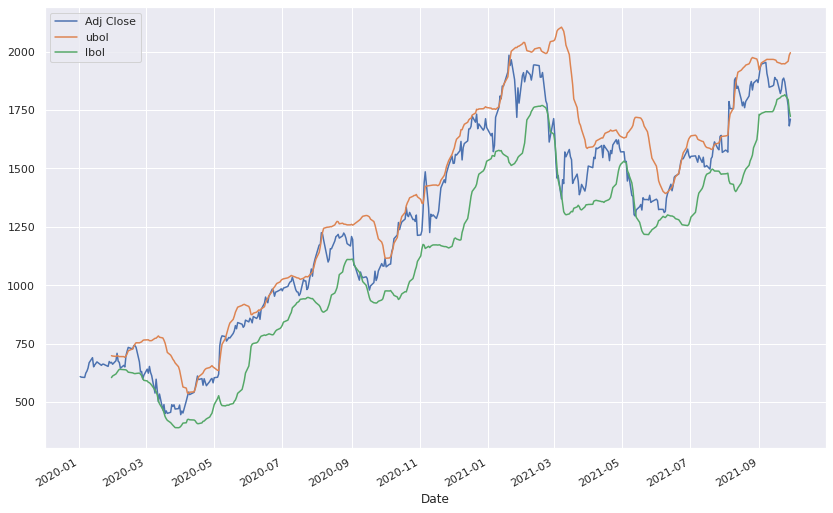

In [38]:
import ta
df["ubol"] = ta.volatility.bollinger_hband(df["Adj Close"])
df["lbol"] = ta.volatility.bollinger_lband(df["Adj Close"])
df[["Adj Close", "ubol", "lbol"]].plot(figsize=(14,9))

# Backtesting de Estrategias

Lo importante aquí es aprender cómo actuar a partir de cada señal que se recibe. Para eso comenzaremos a hacer *backtesting*, es decir, vamos a implementar una estrategia de inversión y la vamos a testear en el pasado, para ver si tiene sentido aplicarla.

Por ejemplo, la "teoría" de las bandas de Bollinger dice que las señales de compra se emiten cuando el precio está por debajo de la banda inferior y habría que vender el activo cuando el precio se va por encima de la banda superior. Es posible hacer de forma automática la señal de las bandas con la librería `ta`, el ejemplo está en su github. Para juntar información de más de una media móvil se puede usar el indicador MACD.

Tenemos que etiquetar nuestros datos si queremos aplicar un poco de aprendizaje supervisado! Para eso, vamos a crear etiquetas simples, para saber si al comprar la acción se ganó dinero. Vamos a tomar el precio de la acción en una fecha y compararlo con el precio en una fecha hacia adelante. Podemos usar una semana, o un mes, o quizás hasta un año. Por ahora, hagamos estrategias diarias y etiquetemos con 1 si, al día siguiente, el precio subió o -1 si el precio bajó.

In [39]:
#Agrego al dataset algunos indicadores de tendencia mencionados anteriormente.
df["SMA_60"] = ta.trend.sma_indicator(df["Adj Close"],window=60)
df["SMA_20"] = ta.trend.sma_indicator(df["Adj Close"],window=20)

In [40]:
df[:50]

,Open,High,Low,Close,Adj Close,Volume,ubol,lbol,SMA_60,SMA_20
Date,,,,,,,,,,
2020-01-02,576.940002,615.840027,576.940002,610.190002,610.190002,589200,NaN,NaN,NaN,NaN
2020-01-03,602.619995,609.840027,600.059998,607.799988,607.799988,320900,NaN,NaN,NaN,NaN
2020-01-06,601.039978,613.789978,601.000000,606.549988,606.549988,209700,NaN,NaN,NaN,NaN
2020-01-07,606.640015,627.969971,604.739990,625.000000,625.000000,480900,NaN,NaN,NaN,NaN
2020-01-08,625.000000,637.820007,624.549988,633.440002,633.440002,334600,NaN,NaN,NaN,NaN
2020-01-09,643.429993,649.049988,638.590027,646.429993,646.429993,413800,NaN,NaN,NaN,NaN
2020-01-10,653.789978,670.150024,648.630005,669.479980,669.479980,680200,NaN,NaN,NaN,NaN
2020-01-13,670.440002,697.219971,670.070007,691.099976,691.099976,660800,NaN,NaN,NaN,NaN
2020-01-14,690.000000,693.979980,649.239990,652.070007,652.070007,976500,NaN,NaN,NaN,NaN


In [41]:
# Creo una nueva columna (Adj Close Sig) que posee el valor Adj Close de la fila siguiente
df['Adj Close Sig'] = df['Adj Close'].shift(-1)

#Etiqueto los datos de acuerdo a la nueva columna creada
df['Target'] = df.apply(lambda x: 1 if (x['Adj Close Sig']) > x['Adj Close'] else -1, axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,ubol,lbol,SMA_60,SMA_20,Adj Close Sig,Target
Date,,,,,,,,,,,,
2020-01-02,576.940002,615.840027,576.940002,610.190002,610.190002,589200,NaN,NaN,NaN,NaN,607.799988,-1
2020-01-03,602.619995,609.840027,600.059998,607.799988,607.799988,320900,NaN,NaN,NaN,NaN,606.549988,-1
2020-01-06,601.039978,613.789978,601.000000,606.549988,606.549988,209700,NaN,NaN,NaN,NaN,625.000000,1
2020-01-07,606.640015,627.969971,604.739990,625.000000,625.000000,480900,NaN,NaN,NaN,NaN,633.440002,1
2020-01-08,625.000000,637.820007,624.549988,633.440002,633.440002,334600,NaN,NaN,NaN,NaN,646.429993,1


Una vez las etiquetas estén listas, comencemos a juntar señales, que van a ser nuestros features! Utilizar algunas de la lista que figura en el Github de `ta`, son muchas, así que tomar algunas que parezcan interesantes o que pueden agregar variabilidad a los resultados (cómo podríamos ver eso?):

#### Volume

* Accumulation/Distribution Index (ADI)
* On-Balance Volume (OBV)
* Chaikin Money Flow (CMF)
* Force Index (FI)
* Ease of Movement (EoM, EMV)
* Volume-price Trend (VPT)
* Negative Volume Index (NVI)

#### Volatility

* Average True Range (ATR)
* Bollinger Bands (BB)
* Keltner Channel (KC)
* Donchian Channel (DC)

#### Trend

* Moving Average Convergence Divergence (MACD)
* Average Directional Movement Index (ADX)
* Vortex Indicator (VI)
* Trix (TRIX)
* Mass Index (MI)
* Commodity Channel Index (CCI)
* Detrended Price Oscillator (DPO)
* KST Oscillator (KST)
* Ichimoku Kinkō Hyō (Ichimoku)

#### Momentum

* Money Flow Index (MFI)
* Relative Strength Index (RSI)
* True strength index (TSI)
* Ultimate Oscillator (UO)
* Stochastic Oscillator (SR)
* Williams %R (WR)
* Awesome Oscillator (AO)

#### Others

* Daily Return (DR)
* Daily Log Return (DLR)
* Cumulative Return (CR)

Vamos a dejarlas en el mismo DataFrame, como hicimos con las bandas de Bollinger. 

### Agregamos algunos features


In [42]:
#Agrego algunos features

# Banda intermedia del canal de Bollinger
df["bb_bbm"] = ta.volatility.bollinger_mavg(df["Adj Close"])

# Banda alta del canal de Bollinger
df["bb_bbh"] = ta.volatility.bollinger_hband(df["Adj Close"])

# Banda baja del canal de Bollinger
df["bb_bbl"] = ta.volatility.bollinger_lband(df["Adj Close"])

# Banda intermedia del canal Keltner
df["ke_mband"] = ta.volatility.keltner_channel_mband(close=df["Close"], low=df["Low"], high=df["High"])
 
# Banda alta del canal Keltner
df["ke_hband"] = ta.volatility.keltner_channel_hband(close=df["Close"], low=df["Low"], high=df["High"])

# Banda baja del canal Keltner
df["ke_lband"] = ta.volatility.keltner_channel_lband(close=df["Close"], low=df["Low"], high=df["High"])

# Banda intermedia de Donchian Channel
df["don_mband"] = ta.volatility.donchian_channel_mband(close=df["Close"], low=df["Low"], high=df["High"])

# Banda alta Donchian Channel
df["don_hband"] = ta.volatility.donchian_channel_hband(close=df["Close"], low=df["Low"], high=df["High"])

# Banda baja Donchian Channel
df["don_lband"] = ta.volatility.donchian_channel_lband(close=df["Close"], low=df["Low"], high=df["High"])


In [43]:
#Agrego algunos features por fuera de volatilidad.

# Volumen Indice de fuerza
df["FI"] = ta.volume.force_index(close=df["Close"],volume=df["Volume"], window=13) #Uso window =13 por convención.

df["EMV"] = ta.volume.ease_of_movement(low=df["Low"], high=df["High"], volume=df["Volume"]) 

df["OBV"] = ta.volume.on_balance_volume(volume=df["Volume"], close=df["Close"]) 

df["VPT"] = ta.volume.volume_price_trend(volume=df["Volume"], close=df["Close"]) 

# Momentum RSI
df["RSI"] = ta.momentum.rsi(close=df["Close"], window=14) #Uso window =14 por convención.

# Tendencia MACD
df["MACD"] = ta.trend.macd(close=df["Close"], window_slow=26,window_fast=12) #Uso window =14 por convención.

# Others Daily return
df["DR_log"] = ta.others.daily_log_return(close=df["Close"]) 

#Volatility
df["ATR"] = ta.volatility.average_true_range(close=df["Close"], low=df["Low"], high=df["High"])
 

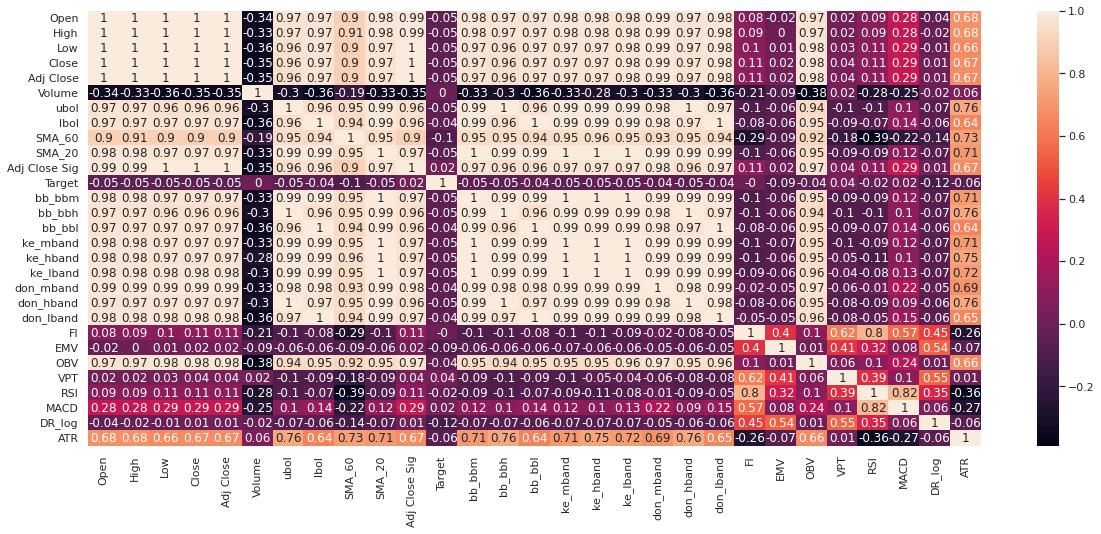

In [44]:
#Que tan correlacionadas estan las variables de AT que agregamos?
# Configuro tamaño
sns.set(rc = {'figure.figsize':(20,8)})
# Defino matriz
correlation_matrix =df.corr().round(2)
# Grafico matriz generada
sns.heatmap(data=correlation_matrix, annot=True) # annot = True me permite imprimir valores.


Observamos que existe una alta correlacion entre las variables que representan indicadores tecnicos de volatildiad.Las bandas de Bollinger, el canal de Keltner y las bandas de Donchian agregan información similar sobre el precio de la acción por lo que permiten que nos quedemos con uno de los indicadores. En este caso consideramos que las bandas de Bollinger son el indicador más conveniente dado que al estar construidos sobre una media movil simple permite suavizar los efectos de los precios máximos y mínimos, y por tanto representar mejor la volatilidad del mercado.
Respecto a los índices de Fuerza Volumen encontramos una fuerte correlación entre los indicadores FI, VPT, EMV Y RSI. En este sentido el indicador RSI resulta a nuestro juicio mas adecuado para el análisis ya que permite identificar divergencias en los movimientos de precios al analizarlos junto a indicadores de tendencia como el MACD.

In [45]:
df[:50]

,Open,High,Low,Close,Adj Close,Volume,ubol,lbol,SMA_60,SMA_20,Adj Close Sig,Target,bb_bbm,bb_bbh,bb_bbl,ke_mband,ke_hband,ke_lband,don_mband,don_hband,don_lband,FI,EMV,OBV,VPT,RSI,MACD,DR_log,ATR
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-02,576.940002,615.840027,576.940002,610.190002,610.190002,589200,NaN,NaN,NaN,NaN,607.799988,-1,NaN,NaN,NaN,NaN,639.890035,562.089986,NaN,NaN,NaN,NaN,NaN,589200,-300946.853705,NaN,NaN,NaN,0.000000
2020-01-03,602.619995,609.840027,600.059998,607.799988,607.799988,320900,NaN,NaN,NaN,NaN,606.549988,-1,NaN,NaN,NaN,NaN,627.785034,579.104980,NaN,NaN,NaN,NaN,26088.197851,268300,-303039.536228,NaN,NaN,-0.392453,0.000000
2020-01-06,601.039978,613.789978,601.000000,606.549988,606.549988,209700,NaN,NaN,NaN,NaN,625.000000,1,NaN,NaN,NaN,NaN,625.157789,584.177768,NaN,NaN,NaN,NaN,14912.350803,58600,-1688.181443,NaN,NaN,-0.205872,0.000000
2020-01-07,606.640015,627.969971,604.739990,625.000000,625.000000,480900,NaN,NaN,NaN,NaN,633.440002,1,NaN,NaN,NaN,NaN,629.485001,587.134995,NaN,NaN,NaN,NaN,43281.436162,539500,14196.727606,NaN,NaN,2.996450,0.000000
2020-01-08,625.000000,637.820007,624.549988,633.440002,633.440002,334600,NaN,NaN,NaN,NaN,646.429993,1,NaN,NaN,NaN,NaN,632.629338,593.441325,NaN,NaN,NaN,NaN,58814.888354,874100,19146.435831,NaN,NaN,1.341364,0.000000
2020-01-09,643.429993,649.049988,638.590027,646.429993,646.429993,413800,NaN,NaN,NaN,NaN,669.479980,1,NaN,NaN,NaN,NaN,636.382775,600.239444,NaN,NaN,NaN,NaN,31938.547268,1287900,13004.259892,NaN,NaN,2.029962,0.000000
2020-01-10,653.789978,670.150024,648.630005,669.479980,669.479980,680200,NaN,NaN,NaN,NaN,691.099976,1,NaN,NaN,NaN,NaN,643.224287,606.095712,NaN,NaN,NaN,NaN,49260.050238,1968100,32739.957330,NaN,NaN,3.503636,0.000000
2020-01-13,670.440002,697.219971,670.070007,691.099976,691.099976,660800,NaN,NaN,NaN,NaN,652.070007,-1,NaN,NaN,NaN,NaN,651.981244,612.706251,NaN,NaN,NaN,NaN,99655.215765,2628900,45593.823454,NaN,NaN,3.178323,0.000000
2020-01-14,690.000000,693.979980,649.239990,652.070007,652.070007,976500,NaN,NaN,NaN,NaN,659.979980,1,NaN,NaN,NaN,NaN,658.409623,613.556297,NaN,NaN,NaN,NaN,-55140.393888,1652400,-33808.288447,NaN,NaN,-5.813257,0.000000


In [46]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ubol', 'lbol',
       'SMA_60', 'SMA_20', 'Adj Close Sig', 'Target', 'bb_bbm', 'bb_bbh',
       'bb_bbl', 'ke_mband', 'ke_hband', 'ke_lband', 'don_mband', 'don_hband',
       'don_lband', 'FI', 'EMV', 'OBV', 'VPT', 'RSI', 'MACD', 'DR_log', 'ATR'],
      dtype='object')

Eliminamos las variables menos correlacionadas ya que nos genera mayor error en el modelo de predicción y menor accuracy

In [47]:
df = df.drop(['SMA_60', 'SMA_20','ubol', 'lbol', 'ke_mband','bb_bbm', 'bb_bbh', 'bb_bbl', 'ke_hband', 'ke_lband', 'DR_log', 'ATR'], axis=1)
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Adj Close Sig',
       'Target', 'don_mband', 'don_hband', 'don_lband', 'FI', 'EMV', 'OBV',
       'VPT', 'RSI', 'MACD'],
      dtype='object')

## ¿Cuáles parecen ser las mejores señales para inferir 'algo'?

Es probable que las mismas cambien a medida que pase el tiempo. Algo *muy importante* al trabajar con datos financieros es separar de forma correcta los datos de training y test, ya que siempre queremos hacer inferencias del futuro en base a datos del pasado (https://www.datapred.com/blog/the-basics-of-backtesting).

Vamos a dividir nuestros datos de forma que podamos entrenar una predicción cada trimestre del año 2020. Para eso vamos a poder usar los datos desde comienzo del 2020.

Hagamos clasificación binaria, ya que tenemos nuestras etiquetas +1 y -1. K Nearest Neighbors parece interesante para hacer esto, pero también se puede probar algún otro clasificador.

Reportar para cada trimestre:

- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

                  Open        High  ...        RSI       MACD
Date                                ...                      
2020-02-07  671.000000  678.219971  ...  46.523098  10.297982
2020-02-10  647.099976  660.969971  ...  50.396961   8.761331
2020-02-11  633.309998  661.989990  ...  48.354806   6.930266
2020-02-12  656.880005  700.960022  ...  60.821763   9.261709
2020-02-13  697.869995  720.690002  ...  64.412922  12.475329
2020-02-14  720.869995  735.239990  ...  67.259616  16.165595
2020-02-18  734.380005  734.380005  ...  65.029683  18.349302
2020-02-19  733.760010  745.000000  ...  67.553284  20.991015
2020-02-20  742.789978  756.479980  ...  67.498235  22.809557
2020-02-21  739.880005  747.419983  ...  64.845669  23.416792
2020-02-24  701.010010  701.010010  ...  47.118470  18.668654
2020-02-25  698.640015  702.000000  ...  39.073182  11.268959
2020-02-26  635.940002  661.840027  ...  39.597089   5.506587
2020-02-27  614.859985  633.169983  ...  34.589271  -1.627539
2020-02-

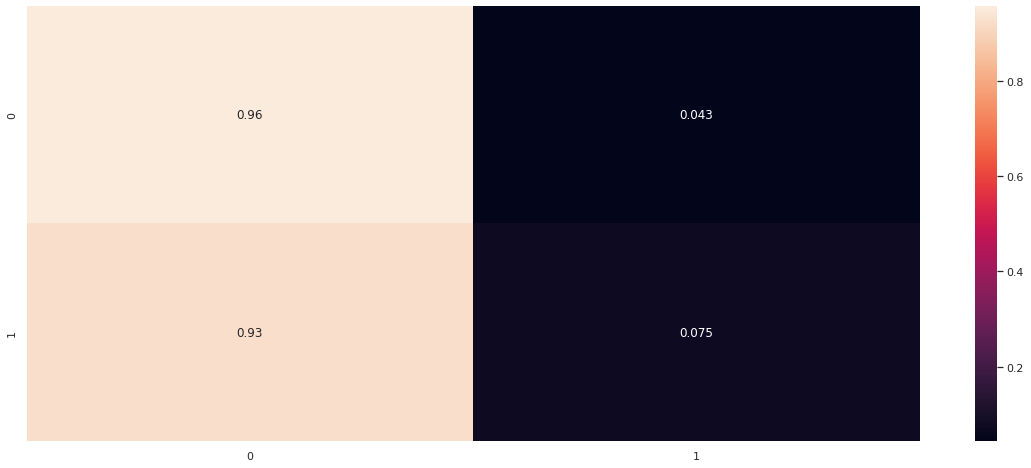

In [48]:
# Elimino los NaN
df.dropna(inplace=True)

# Separo test y train
# Train (1/01/2020)
start_train = datetime.datetime(year=2020, month=1, day=1)

# Test (1/04/2020)
start_test = start_train + dateutil.relativedelta.relativedelta(months=3)

# Fin train (31/03/2020)
end_train = start_test - timedelta(days=1)

# Fin test (31/06/2020)
end_test = start_test + dateutil.relativedelta.relativedelta(months=3) - timedelta(days=1) 

# Filtro por los rangos de fechas de 3 meses
df_train=df[start_train:end_train]
df_test=df[start_test:end_test]

# Convierto el index de df_train
df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')

# Elimino Target para X_Train
X_train = df_train.drop(['Target'], axis=1)

# Defino y_train
y_train = df_train.Target
print(X_train)
print(y_train)

# Elimino Target para X_test
X_test = df_test.drop(['Target'], axis=1)

# Defino y_test
y_test = df_test.Target
   
# Entreno el modelo
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
  
# Predicción con los datos de train
y_predict_train = neigh.predict(X_train)

# Preicción con los datos de test
y_predict_test = neigh.predict(X_test)
print(y_predict_test)

# Impresión de los predict
print(classification_report(y_test, y_predict_test))
print(classification_report(y_train, y_predict_train))

# Devolvemos el predict y el error
sns.heatmap(confusion_matrix(y_test, y_predict_test, normalize='true'),annot=True)

## Finalmente, probar la estrategia

Si tomamos la decisión de comprar la acción cuando la etiqueta es +1 y vender (quedarnos con el dinero) cuando la etiqueta es -1 al comienzo de cada día desde el 01/04/2020, cómo nos habrá ido? Supongamos que comenzamos con \$10.000 y tomemos la diferencia porcentual entre el precio de Cierre del primer día de cada mes para ver si ganamos dinero. Con esto completaríamos un flow de backtesting y vamos a poder evaluar si esta estrategia funciona con la acción MELI.

Si hay tiempo, se puede usar esto para otras acciones.

In [49]:
# Fecha start 01/04/2020
start = datetime.datetime(year=2020, month=4, day=1)

# Fecha finalización 3 meses después
end = start_test + dateutil.relativedelta.relativedelta(months=3)

In [50]:
# Filtro por fecha start y fecha end el df
df_04=df[start:end]
df_04.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close Sig,Target,don_mband,don_hband,don_lband,FI,EMV,OBV,VPT,RSI,MACD
Date,,,,,,,,,,,,,,,,,
2020-04-01,466.000000,468.989990,435.040009,447.339996,447.339996,965500,462.869995,1,475.455017,647.659973,422.220001,-6.766754e+06,-121963.234802,-225600,-60109.395528,36.677435,-41.830944
2020-04-02,445.470001,472.200012,443.000000,462.869995,462.869995,795000,454.470001,-1,475.455017,618.059998,422.220001,-4.036310e+06,20513.492355,569400,-53896.312144,39.730473,-40.469649
2020-04-03,452.720001,460.959991,443.010010,454.470001,454.470001,868500,506.160004,1,472.114990,599.080017,422.220001,-4.501894e+06,-11604.979365,-299100,11838.257396,38.645145,-39.612000
2020-04-06,473.880005,509.250000,470.089996,506.160004,506.160004,688300,525.669983,1,476.944992,599.080017,422.220001,1.223838e+06,214404.277554,389200,62523.880644,48.049685,-34.365215
2020-04-07,547.190002,554.929993,507.589996,525.669983,525.669983,711400,544.000000,1,494.985001,583.440002,422.220001,3.031775e+06,276759.948598,1100600,105706.070112,51.096615,-28.306508


In [51]:
# Defino el nuevo dataset para predecir
X_04 = df_04.drop(['Target'], axis=1)

In [52]:
# Calculo las predicciones para inicio 1/04/2020 y fin 3 meses después
y_predict_04 = neigh.predict(X_04)

In [53]:
# Defino un nuevo dataframe
df_with_predict_04 = X_04
df_with_predict_04

,Open,High,Low,Close,Adj Close,Volume,Adj Close Sig,don_mband,don_hband,don_lband,FI,EMV,OBV,VPT,RSI,MACD
Date,,,,,,,,,,,,,,,,
2020-04-01,466.000000,468.989990,435.040009,447.339996,447.339996,965500,462.869995,475.455017,647.659973,422.220001,-6.766754e+06,-121963.234802,-225600,-60109.395528,36.677435,-41.830944
2020-04-02,445.470001,472.200012,443.000000,462.869995,462.869995,795000,454.470001,475.455017,618.059998,422.220001,-4.036310e+06,20513.492355,569400,-53896.312144,39.730473,-40.469649
2020-04-03,452.720001,460.959991,443.010010,454.470001,454.470001,868500,506.160004,472.114990,599.080017,422.220001,-4.501894e+06,-11604.979365,-299100,11838.257396,38.645145,-39.612000
2020-04-06,473.880005,509.250000,470.089996,506.160004,506.160004,688300,525.669983,476.944992,599.080017,422.220001,1.223838e+06,214404.277554,389200,62523.880644,48.049685,-34.365215
2020-04-07,547.190002,554.929993,507.589996,525.669983,525.669983,711400,544.000000,494.985001,583.440002,422.220001,3.031775e+06,276759.948598,1100600,105706.070112,51.096615,-28.306508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,950.349976,972.950012,944.349976,971.440002,971.440002,333100,973.169983,933.669983,998.109985,830.950012,3.871649e+06,-56753.736393,11196700,-4998.569217,68.264921,53.231494
2020-06-26,974.510010,985.030029,952.619995,973.169983,973.169983,500800,980.830017,937.565002,998.109985,837.760010,3.442324e+06,65849.179557,11697500,7063.009422,68.480843,52.246105
2020-06-29,970.299988,987.000000,949.979980,980.830017,980.830017,335500,985.770020,960.100006,998.109985,837.760010,3.317698e+06,-3696.727264,12033000,3532.639335,69.471308,51.489736


In [54]:
# Agrego el Predict al nuevo dataframe
df_with_predict_04['Predict'] = y_predict_04
df_with_predict_04

,Open,High,Low,Close,Adj Close,Volume,Adj Close Sig,don_mband,don_hband,don_lband,FI,EMV,OBV,VPT,RSI,MACD,Predict
Date,,,,,,,,,,,,,,,,,
2020-04-01,466.000000,468.989990,435.040009,447.339996,447.339996,965500,462.869995,475.455017,647.659973,422.220001,-6.766754e+06,-121963.234802,-225600,-60109.395528,36.677435,-41.830944,-1
2020-04-02,445.470001,472.200012,443.000000,462.869995,462.869995,795000,454.470001,475.455017,618.059998,422.220001,-4.036310e+06,20513.492355,569400,-53896.312144,39.730473,-40.469649,-1
2020-04-03,452.720001,460.959991,443.010010,454.470001,454.470001,868500,506.160004,472.114990,599.080017,422.220001,-4.501894e+06,-11604.979365,-299100,11838.257396,38.645145,-39.612000,1
2020-04-06,473.880005,509.250000,470.089996,506.160004,506.160004,688300,525.669983,476.944992,599.080017,422.220001,1.223838e+06,214404.277554,389200,62523.880644,48.049685,-34.365215,-1
2020-04-07,547.190002,554.929993,507.589996,525.669983,525.669983,711400,544.000000,494.985001,583.440002,422.220001,3.031775e+06,276759.948598,1100600,105706.070112,51.096615,-28.306508,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-25,950.349976,972.950012,944.349976,971.440002,971.440002,333100,973.169983,933.669983,998.109985,830.950012,3.871649e+06,-56753.736393,11196700,-4998.569217,68.264921,53.231494,-1
2020-06-26,974.510010,985.030029,952.619995,973.169983,973.169983,500800,980.830017,937.565002,998.109985,837.760010,3.442324e+06,65849.179557,11697500,7063.009422,68.480843,52.246105,-1
2020-06-29,970.299988,987.000000,949.979980,980.830017,980.830017,335500,985.770020,960.100006,998.109985,837.760010,3.317698e+06,-3696.727264,12033000,3532.639335,69.471308,51.489736,-1


In [55]:
# Cambio el nombre de la columna Adj Close a AdjClose
df_with_predict_04 = df_with_predict_04.rename({'Adj Close': 'AdjClose'}, axis=1) 

# Defino valores iniciales
cant_money = 10000
cant_stocks = 0
values_before = None

# Recorro el dataframe para analizar la columna target y analizar si comprar o vender
for index, values in df_with_predict_04.iterrows():
    
    # Si el valor de Target anterior es diferente realizó una acción de compra o venta de lo contrario
    # si el valor es igual no realizo ninguna acción
    if values_before is None or values_before != values.Predict:
      
      if values.Predict == 1:
          # Comprar
          cant_stocks = cant_money / values.AdjClose
          cant_money = 0
          print("Acción comprar-", "Cantidad de stocks:", cant_stocks, "Cantidad money:", cant_money, "Fecha:", index)
      else:
        if not values_before is None:
           # Vender 
           cant_money = cant_stocks * values.AdjClose
           cant_stocks = 0
           print("Acción vender-", "Cantidad de stocks:", cant_stocks, "Cantidad money:", cant_money, "Fecha:", index)
    values_before = values.Predict

# Forzar venta
if cant_money == 0:
    cant_money = df_with_predict_04['AdjClose'][-1] * cant_stocks
    print('FORZAR')
print("Cantidad:", cant_money)

Acción comprar- Cantidad de stocks: 22.003652547231 Cantidad money: 0 Fecha: 2020-04-03 00:00:00
Acción vender- Cantidad de stocks: 0 Cantidad money: 11137.368853886224 Fecha: 2020-04-06 00:00:00
Acción comprar- Cantidad de stocks: 18.92050927006375 Cantidad money: 0 Fecha: 2020-04-15 00:00:00
Acción vender- Cantidad de stocks: 0 Cantidad money: 11592.785650594607 Fecha: 2020-04-16 00:00:00
Acción comprar- Cantidad de stocks: 19.40215171647633 Cantidad money: 0 Fecha: 2020-04-17 00:00:00
Acción vender- Cantidad de stocks: 0 Cantidad money: 11124.805845930267 Fecha: 2020-04-21 00:00:00
Cantidad: 11124.805845930267


Si compramos la acción el 1/04/2020 y luego la vendemos a los 3 meses

In [56]:
# 3 meses
stocks = 10000 / df_with_predict_04['AdjClose'][0]
money = stocks * df_with_predict_04['AdjClose'][-1]
print("Valor de la acción día 1/04/2020:", df_with_predict_04['AdjClose'][-1])
print("Valor de la acción 3 meses después:", df_with_predict_04['AdjClose'][0])
print("Stocks:", stocks)
print("Money:", money)

Valor de la acción día 1/04/2020: 977.1400146484375
Valor de la acción 3 meses después: 447.3399963378906
Stocks: 22.35436151889864
Money: 21843.341142033085


Si compramos la acción el 1/04/2020 y luego la vendemos al mes

In [57]:
# 1 mes
stocks = 10000 / df_with_predict_04['AdjClose'][0]
money = stocks * df_with_predict_04['AdjClose'][-60]
print("Valor de la acción día 1/04/2020:", df_with_predict_04['AdjClose'][-1])
print("Valor de la acción 1 mes después:", df_with_predict_04['AdjClose'][0])
print("Stocks:", stocks)
print("Money:", money)

Valor de la acción día 1/04/2020: 977.1400146484375
Valor de la acción 1 mes después: 447.3399963378906
Stocks: 22.35436151889864
Money: 11751.016837606901


**Según el modelo**

Si nosotros compramos la acción el 1/04/2020 según el modelo deberíamos comprar y vender 3 veces en un rango de 3 meses.

* Acción comprar- Cantidad de stocks: 22.003652547231 Cantidad money: 0 Fecha: 2020-04-03 00:00:00
* Acción vender- Cantidad de stocks: 0 Cantidad money: 11137.368853886224 Fecha: 2020-04-06 00:00:00
* Acción comprar- Cantidad de stocks: 18.92050927006375 Cantidad money: 0 Fecha: 2020-04-15 00:00:00
* Acción vender- Cantidad de stocks: 0 Cantidad money: 11592.785650594607 Fecha: 2020-04-16 00:00:00
* Acción comprar- Cantidad de stocks: 19.40215171647633 Cantidad money: 0 Fecha: 2020-04-17 00:00:00
* Acción vender- Cantidad de stocks: 0 Cantidad money: 11124.805845930267 Fecha: 2020-04-21 00:00:00
* Cantidad: 11124.805845930267

Luego del mes el modelo predice todos valores en -1 es decir que hay que vender. 


**Con los valores Adj Close reales de la acción - 3 meses**

Ahora si realizamos el calculo de compra la acción el 1/04/2020 y la vendemos a los 3 meses:
* Valor de la acción día 1/04/2020: 977.1400146484375
* Valor de la acción 3 meses después: 447.3399963378906
* Stocks: 22.35436151889864
* Money: 21843.341142033085

**Con los valores Adj Close reales de la acción - 1 mes**

Ahora si realizamos el calculo de compra la acción el 1/04/2020 y la vendemos al mes:
* Valor de la acción día 1/04/2020: 977.1400146484375
* Valor de la acción 1 mes después: 447.3399963378906
* Stocks: 22.35436151889864
* Money: 11751.016837606901


